# Bigrams: Next Character prediction

In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
words = open("names.txt", "r").read().splitlines()

print("First few words:", words[:5])

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# Basic stats on names
print("Length of words:", len(words))
print("Minimum length:", min(len(w) for w in words))
print("Maximum length:", max(len(w) for w in words))
print("Average length:", sum(len(w) for w in words) / len(words))

Length of words: 32033
Minimum length: 2
Maximum length: 15
Average length: 6.122217712983486


Explore bigrams

In [4]:
bigrams = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1

# print(bigrams)

# top 10 Most common bigrams
sorted(bigrams.items(), key= lambda kv: kv[1], reverse=True)[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

## Globals

In [5]:
VOCAB  = ['.'] + sorted(set("".join(words)))
NVOCAB = len(VOCAB) # 26 letters + .

## Counts model

In [6]:
# define the tensor to hold the bigram counts
N = torch.zeros((NVOCAB, NVOCAB), dtype=torch.int32)

In [7]:
# Helper lookups
stoi = {c:i for i,c in enumerate(VOCAB)}
itos = {i:c for c,i in stoi.items()}

In [8]:
# populate the bigram counts
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

# Each row indicates the counts of bigrams of letters following the first letter
print("Count of bigrams following character . \n", {itos[i]:c.item() for i, c in enumerate(N[0])})

Count of bigrams following character . 
 {'.': 0, 'a': 4410, 'b': 1306, 'c': 1542, 'd': 1690, 'e': 1531, 'f': 417, 'g': 669, 'h': 874, 'i': 591, 'j': 2422, 'k': 2963, 'l': 1572, 'm': 2538, 'n': 1146, 'o': 394, 'p': 515, 'q': 92, 'r': 1639, 's': 2055, 't': 1308, 'u': 78, 'v': 376, 'w': 307, 'x': 134, 'y': 535, 'z': 929}


Visualize bigrams in the datase

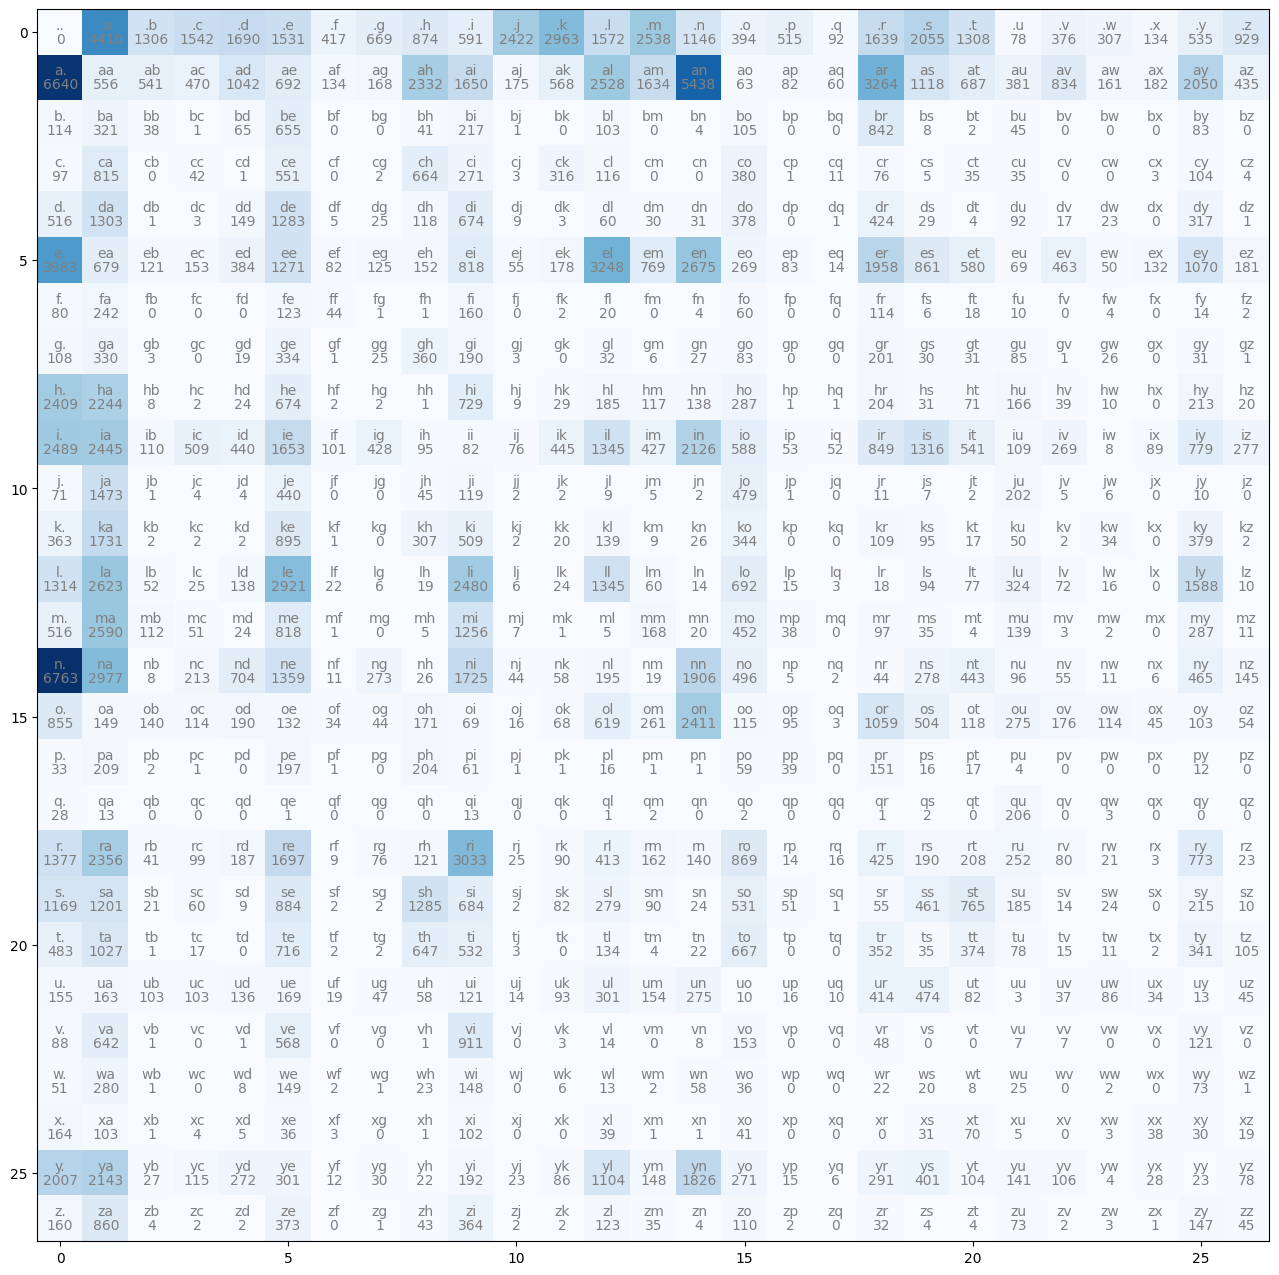

In [9]:
# plot the bigram counts matrix
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(NVOCAB):
    for j in range(NVOCAB):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")

## Bigram counts to probabilities

Convert the bigram counts of each character into probabilities by taking the dividing each row by it's rowsum

In [10]:
# Bigram counts to probabilities
P = (N+1).float() # + 1 is added so that no bigrams are assigned 0 probability. 
P /= P.sum(dim=1, keepdim=True)

# verify the sum of elements is 1
assert P[0].sum() == 1

Now we have a probability distribution model of all bigrams. Next we can generate names using the distibution

> Note: 1 is added to the counts matrix `N`. This is to ensure no bigrams are assigened zero probabilites. This ensures the model to generalize to the out-of-distribution(unseen) bigrams. The act of ensuring the probabiliites are non-zero is called smoothing. Adding a bigger number ensures the proabilites are properly distriubted. Very large number would mean we have uniform distribution of probabilities.

## Generate words

We can develop a name generator that samples form the probability distibution and creates new words

In [11]:
# Set seed for the rng functions for reproducibility
g = torch.Generator().manual_seed(2147483647)       # torch.manual_seed() is used for setting the seed globally

for i in range(5):
    out = []
    # set starting index : each name starts with as '.' character
    ix = 0  # Index of . character
    while True:
        p = P[ix] # select the bigram distribution of first char
        # get next char by sampling the distribution
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        # if we reached end of name indicated by '.'
        if ix == 0:
            break

    print("".join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


## Compute Loss

The goal of a language model is to maximize likelihood of the data w.r.t. model parameters (statistical modeling)
- equivalent to maximizing the log likelihood (because log is monotonic)
- equivalent to minimizing the negative log likelihood
- equivalent to minimizing the average negative log likelihood

Note: Logrithimic property: $log(a*b*c) = log(a) + log(b) + log(c)$

In [12]:
# compute the log liklihood
log_likelihood = 0.0
n = 0
for w in words:
    chs = "." + w + "."
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = prob.log()
        log_likelihood += logprob
        n += 1 # increment by 1


print(f'{log_likelihood=}')

# negative log likelihood
nll = - log_likelihood
# average it by bigram counts
print(f'{nll/n=}')


log_likelihood=tensor(-559951.5625)
nll/n=tensor(2.4544)


In this section we have developed a bigram model based on statisical probability distribution in the data. The Negative log likelihood loss in this approach is 2.45

## Basic Neural Network model

We will develop a very basic neural network based approach for bigram next character  prediction

The neural network will take first bigram character as input and predict next character as output.

Split data into input and outputs. 

In [13]:
x, y = [], []
for w in words[:1]:
    chs = "." + w + "."
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        x.append(ix1)
        y.append(ix2)

# convert them to tensors
x = torch.tensor(x)
y = torch.tensor(y)

print (x, y)

tensor([ 0,  5, 13, 13,  1]) tensor([ 5, 13, 13,  1,  0])


## Vectorize: One-hot encoding

Given a input character we need to predict the next character as output. One way to do is to train the model to predict the likelihoods of all the characters in vocabulary as output. So we can choose the character with high likelihood as output. 

One way of achieving this is by one-hot encoding character with vocabulary and passing it as input. This means the input is a 27 dimensional vector. The neural netwok model will learn the output probabilities for the next character from the training data.  

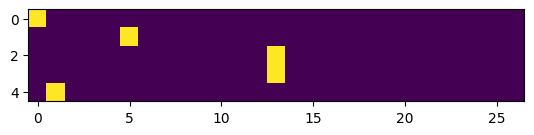

In [14]:
# Lets one hot encode first five characters.
xenc = F.one_hot(x, num_classes=NVOCAB)
plt.imshow(xenc)

In [15]:
xenc.shape

torch.Size([5, 27])

Note: Neural networks do not work with discrete inputs. Conver the dtype to float.

## Forward Pass

The simple neural network shall have the following archtecture

``` 
    Inputs               ----> 27 Neurons         ----> Output
    [nbigrams x 27]            [27 x 27]             [nbigrams x 27]

```

In [16]:
# randomly initialize the weight matrix
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((NVOCAB, NVOCAB), generator=g, requires_grad=True)
xlen = x.nelement()

# forward pass
xenc = F.one_hot(x, num_classes=NVOCAB).float()
logits = xenc @ W # log-counts
counts = logits.exp() # counts
probs = counts/counts.sum(dim=1, keepdim=True) # convert counts to char # softmax operation

Now that we have probability distribution like before. Let's compute the negative log likelihood for few of our first word example

In [17]:
nlls = torch.zeros(5)
for i in range(5):
    print("-"*50)
    inp = x[i].item()
    out = y[i].item()
    print(f"bigram : {itos[inp]}{itos[out]} (indices {inp},{out})")
    print(f"input to neural network: {itos[inp]}")
    p = probs[i, out]
    print(f"probability of {itos[out]} following {itos[inp]}: {p}")
    nll = -p.log() # negative log of p
    print(f"{nll.item()=}")
    nlls[i] = nll

print("="*50)
print("Average negative log likelihood:", nlls.mean().item())

--------------------------------------------------
bigram : .e (indices 0,5)
input to neural network: .
probability of e following .: 0.012286250479519367
nll.item()=4.3992743492126465
--------------------------------------------------
bigram : em (indices 5,13)
input to neural network: e
probability of m following e: 0.018050704151391983
nll.item()=4.014570713043213
--------------------------------------------------
bigram : mm (indices 13,13)
input to neural network: m
probability of m following m: 0.026691533625125885
nll.item()=3.623408794403076
--------------------------------------------------
bigram : ma (indices 13,1)
input to neural network: m
probability of a following m: 0.07367684692144394
nll.item()=2.6080667972564697
--------------------------------------------------
bigram : a. (indices 1,0)
input to neural network: a
probability of . following a: 0.01497753243893385
nll.item()=4.2012038230896
Average negative log likelihood: 3.7693049907684326


## Gradient Decent

In [18]:
# initalizations
EPOCHS = 1000
LR = 50 # learning rate
L2 = 0.01 # regularization

# create dataset 
x, y = [], []
for w in words:
    chs = "." + w + "."
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        x.append(ix1)
        y.append(ix2)

# convert them to tensors
x = torch.tensor(x)
y = torch.tensor(y)
xlen = x.nelement()
print("number of inputs: ", xlen)

# seed rng for repeatability
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((NVOCAB, NVOCAB), generator=g, requires_grad=True)

print("dimensions of weight matrix: ",W.shape)

number of inputs:  228146
dimensions of weight matrix:  torch.Size([27, 27])


In [19]:
for i in range(EPOCHS):
    # forward pass
    xenc = F.one_hot(x, num_classes=NVOCAB).float()
    logits = xenc @ W # log-counts
    counts = logits.exp() # counts
    probs = counts/counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(xlen), y].log().mean() + L2 * (W**2).mean() # negative log likelihood
    print(f"Loss at {i+1}/{EPOCHS}:", loss.item())

    # backward pass
    W.grad = None # setting gradients to zero
    loss.backward()

    # update Weights
    W.data +=  - LR* W.grad  



    

Loss at 1/1000: 3.7686190605163574
Loss at 2/1000: 3.3787858486175537
Loss at 3/1000: 3.1610772609710693
Loss at 4/1000: 3.027181386947632
Loss at 5/1000: 2.9344801902770996
Loss at 6/1000: 2.8672285079956055
Loss at 7/1000: 2.816653251647949
Loss at 8/1000: 2.7771458625793457
Loss at 9/1000: 2.745253562927246
Loss at 10/1000: 2.7188305854797363
Loss at 11/1000: 2.696505546569824
Loss at 12/1000: 2.6773722171783447
Loss at 13/1000: 2.6608054637908936
Loss at 14/1000: 2.6463515758514404
Loss at 15/1000: 2.633665084838867
Loss at 16/1000: 2.622471332550049
Loss at 17/1000: 2.6125471591949463
Loss at 18/1000: 2.6037063598632812
Loss at 19/1000: 2.595794439315796
Loss at 20/1000: 2.5886809825897217
Loss at 21/1000: 2.5822560787200928
Loss at 22/1000: 2.5764293670654297
Loss at 23/1000: 2.5711233615875244
Loss at 24/1000: 2.566272497177124
Loss at 25/1000: 2.5618226528167725
Loss at 26/1000: 2.5577261447906494
Loss at 27/1000: 2.5539441108703613
Loss at 28/1000: 2.550442695617676
Loss at 29

Regularize the model is the act of smoothing the probabilities of unseen bigrams in data. This is done by the `L2*(W**2).mean()` term in loss function.

Genearte words with neural network model

In [20]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        # forward pass
         # forward pass
        xenc = F.one_hot(torch.tensor([ix]), num_classes=NVOCAB).float()
        logits = xenc @ W # log-counts
        counts = logits.exp() # counts
        p = counts/counts.sum(dim=1, keepdim=True)

        
        # sample next char from distribution
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        if ix == 0:
            break


    print("".join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


## Conclusion

The output of the neural network model is the carbon copy of bigram statistical model. 

The neural network model arrived at the same outputs driven by data. 

The nerual network is much more flexible which can handle much more complex langague modeling tasks.

# Exercise 01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?


## Statistical modelling: Trigram

The trigram model predicts the third charcter based on first two characters. 

> Notes: Uses the approach from bigram.

In [21]:
# load datas
words = open("names.txt", "r").read().splitlines()

# trigrams. first two chras followed by last char
trigrams = {}
for w in words:
    chs = "." + w + "."

    for i in range(len(chs)-2):
        ch1 = chs[i:i+2]
        ch2 = chs[i+2]
        trigram = (ch1, ch2)
        trigrams[trigram] = trigrams.get(trigram, 0) + 1



print(sorted(trigrams.items(), key=lambda kv: kv[1], reverse=True)[:10])

[(('ah', '.'), 1714), (('na', '.'), 1673), (('an', '.'), 1509), (('on', '.'), 1503), (('.m', 'a'), 1453), (('.j', 'a'), 1255), (('.k', 'a'), 1254), (('en', '.'), 1217), (('ly', 'n'), 976), (('yn', '.'), 953)]


### Counts model

In [22]:
VOCAB = ["."] + sorted(set("".join(words)))
NINPUT = len(VOCAB)**2
NOUTPUT = len(VOCAB)

Create a probability matrix with rows representing the `bigram` inputs and outputs character

In [23]:

from itertools import product
# lookups
stoi_in = {chs[0]+chs[1]:i for i, chs  in enumerate(product(VOCAB, repeat=2))}
itos_in = {i:c for c,i in stoi_in.items()}

stoi_out = {c:i for i,c in enumerate(VOCAB)}
itos_out = {i:c for c,i in stoi_out.items()}

assert len(stoi_in)==len(VOCAB)**2

print(f"Dimension of probability matrix: ({len(stoi_in)},{len(stoi_out)})")

Dimension of probability matrix: (729,27)


In [24]:
# # count trigrams
# N = torch.zeros((len(stoi_in), len(stoi_out)))
# for w in words:
#     chs = "." + w + "."

#     for i in range(len(chs)-2):
#         ch1, ch2 = chs[i:i+2], chs[i+2]
#         ix1 = stoi_in[ch1]
#         ix2 = stoi_out[ch2]
#         N[ix1,ix2] += 1


# # smoothen the counts by adding one
# N = (N+1).float()
# P = N/N.sum(dim=1, keepdim=True)

In [25]:
# count trigrams
N = torch.zeros((len(stoi_in), len(stoi_out)))
for w in words:
    chs = ".." + w + ".."

    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        ix1 = stoi_in[ch1]
        ix2 = stoi_out[ch2]
        N[ix1,ix2] += 1


# smoothen the counts by adding one
N = (N+1).float()
P = N/N.sum(dim=1, keepdim=True)

> Note: Beware of pytorch boradcasting rules.

729, 27 

729, 1 # `N.sum(dim=1,keepdim=True) sums all the columns and keep the dims so you get a column vector`

"""
If two tensors x, y are “broadcastable”, the resulting tensor size is calculated as follows:

If the number of dimensions of x and y are not equal, prepend 1 to the dimensions of the tensor with fewer dimensions to make them equal length.

Then, for each dimension size, the resulting dimension size is the max of the sizes of x and y along that dimension.
"""

In [26]:
# rows of the matrix are probabilities so they should sum to 1
assert P[0].sum().item() == 1 

### Generate names

In [27]:
# # Set seed for the rng functions for reproducibility
# g = torch.Generator().manual_seed(2147483647)       # torch.manual_seed() is used for setting the seed globally

# for i in range(5):
#     out = []
#     # set starting index : each name starts with as '.' character
#     ix = 0  # Index of .. character
#     while True:
#         p = P[ix] # select the bigram distribution of first char
#         # get next char by sampling the distribution
#         ix_out = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
#         chs = itos_in[ix][-1] + itos_out[ix_out] # construct next bigram by taking last character of last bigram and predicted output
#         ix = stoi_in[chs]
#         out.append(itos_out[ix_out])
#         # if we reached end of name indicated by '.'
#         if ix_out == 0:
#             break

#     print("".join(out))

In [28]:
# Set seed for the rng functions for reproducibility
g = torch.Generator().manual_seed(2147483647)       # torch.manual_seed() is used for setting the seed globally

for i in range(5):
    out = []
    # set starting index
    ix = 0
    while True:
        p = P[ix] 
        nix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        chs = itos_in[ix][-1] + itos_out[nix]
        ix = stoi_in[chs]
        out.append(itos_out[nix])
        if nix == 0:
            break

    print("".join(out))

ce.
bra.
jalius.
rochityharlonimittain.
luwak.


### Compute loss

In [29]:
# # compute the log liklihood
# log_likelihood = 0.0
# n = 0
# for w in words:
#     chs = "." + w + "."
#     for i in range(len(chs)-2):
#         ch1, ch2 = chs[i:i+2], chs[i+2]
#         ix1 = stoi_in[ch1]
#         ix2 = stoi_out[ch2]
#         prob = P[ix1,ix2]
#         logprob = prob.log()
#         log_likelihood += logprob
#         n += 1 # increment by 1


# print(f'{log_likelihood=}')

# # negative log likelihood
# nll = - log_likelihood
# # average it by bigram counts
# print(f'{nll/n=}')


In [30]:
# compute the log liklihood
log_likelihood = 0.0
n = 0
for w in words:
    chs = ".." + w + ".."
    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        ix1 = stoi_in[ch1]
        ix2 = stoi_out[ch2]
        prob = P[ix1,ix2]
        logprob = prob.log()
        log_likelihood += logprob
        n += 1 # increment by 1


print(f'{log_likelihood=}')

# negative log likelihood
nll = - log_likelihood
# average it by bigram counts
print(f'{nll/n=}')


log_likelihood=tensor(-505260.7500)
nll/n=tensor(1.9420)


**Neagative loglikelihood loss of the Statistical Trigram model is 2.092. It's better than bigram model's 2.45**

## Neural Network

### Prepare dataset

In [31]:
# # Create dataset
# xs, ys = [], []

# for w in words:
#     chs = "." + w + "."
#     for i in range(len(chs)-2):
#         ch1, ch2 = chs[i:i+2], chs[i+2]
#         xs.append(stoi_in[ch1])
#         ys.append(stoi_out[ch2])
        
# # convert to tensor
# xs = torch.tensor(xs)
# ys = torch.tensor(ys)

# xlen = xs.nelement()
# print("Number of samples :", xlen)


In [32]:
# Create dataset
xs, ys = [], []

for w in words:
    chs = ".." + w + ".."
    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        xs.append(stoi_in[ch1])
        ys.append(stoi_out[ch2])
        
# convert to tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

xlen = xs.nelement()
print("Number of samples :", xlen)


Number of samples : 260179


### Train model

In [33]:
# Initializations
EPOCHS = 1000
LR = 100
L2 = 0.01
# seed rng for repeatability
g = torch.Generator().manual_seed(2147483647)
# neuron weight matrix
W = torch.randn((NINPUT, NOUTPUT), generator=g, requires_grad=True)
print(f"{W.shape=}")

W.shape=torch.Size([729, 27])


**Training loop**

In [34]:
for i in range(EPOCHS):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=NINPUT).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(xlen), ys].log().mean() + L2*(W**2).mean()  # nll
    print(f"Loss at {i+1}/{EPOCHS}:", loss.item())

    # Backward pass
    W.grad = None
    loss.backward()
    W.data += -LR*W.grad # upddate weights

Loss at 1/1000: 3.7523207664489746
Loss at 2/1000: 3.3785970211029053
Loss at 3/1000: 3.195969581604004
Loss at 4/1000: 3.0842132568359375
Loss at 5/1000: 2.9990122318267822
Loss at 6/1000: 2.928872585296631
Loss at 7/1000: 2.869108200073242
Loss at 8/1000: 2.8172616958618164
Loss at 9/1000: 2.7717199325561523
Loss at 10/1000: 2.7313458919525146
Loss at 11/1000: 2.6953020095825195
Loss at 12/1000: 2.662945032119751
Loss at 13/1000: 2.6337497234344482
Loss at 14/1000: 2.607271432876587
Loss at 15/1000: 2.5831334590911865
Loss at 16/1000: 2.5610227584838867
Loss at 17/1000: 2.5406806468963623
Loss at 18/1000: 2.521894931793213
Loss at 19/1000: 2.504488229751587
Loss at 20/1000: 2.4883100986480713
Loss at 21/1000: 2.4732301235198975
Loss at 22/1000: 2.459134340286255
Loss at 23/1000: 2.445922613143921
Loss at 24/1000: 2.4335055351257324
Loss at 25/1000: 2.4218056201934814
Loss at 26/1000: 2.4107534885406494
Loss at 27/1000: 2.4002890586853027
Loss at 28/1000: 2.3903586864471436
Loss at 29

### Genearte words

In [35]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    ix = 0
    while True:
        # ----------
        # BEFORE:
        # p = P[ix]
        # ----------
        # NOW:
        # forward pass
        xenc = F.one_hot(torch.tensor([ix]), num_classes=NINPUT).float()
        logits = xenc @ W # log-counts
        counts = logits.exp() # counts
        p = counts/counts.sum(dim=1, keepdim=True)

        
        # sample next char from distribution
        ix_out = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        chs = itos_in[ix][-1] + itos_out[ix_out] # construct next bigram by taking last character of last bigram and predicted output
        ix = stoi_in[chs]
        out.append(itos_out[ix_out])
        # if we reached end of name indicated by '.'
        if ix_out == 0:
            break

    print("".join(out))

ce.
bra.
jalius.
rochityharlonimittain.
luwan.
ka.
da.
samiyah.
javer.
gotai.
moriellavojkwu.
eda.
kaley.
maside.
en.
aviony.
fobspihaniven.
tahlas.
kashrxdleenlen.
al.


In [36]:
# P[X]
print("""
      P[X]: Probabilistic trigram model
ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.
moriellavojkwuthda.
kaley.
maside.
en.
aviyah.
fobspihiliven.
tahlasuzusfxx.
an.
glhpynn.
isan.
""")


      P[X]: Probabilistic trigram model
ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.
moriellavojkwuthda.
kaley.
maside.
en.
aviyah.
fobspihiliven.
tahlasuzusfxx.
an.
glhpynn.
isan.



## Conclusion:
Developed trigram language model with 2 approaches
1. Probabilistic model <NLL Loss = 2.0927>
2. Neural Network model <NLL Loss = 2.1069>

>Note: Generated names of these approaches are not same like bigrams.

# E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

## Prepare datasets

In [37]:
# Create dataset
xs, ys = [], []

for w in words:
    chs = "." + w + "."
    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        xs.append(stoi_in[ch1])
        ys.append(stoi_out[ch2])
        
# convert to tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Split data into train and test splits
train_split= int(0.8 * len(xs)) 
val_split = int(0.1 * len(xs))
# test_split = int(0.1 * len(xs))
xt, yt = xs[:train_split], ys[:train_split]
xv, yv = xs[train_split: train_split+val_split], ys[train_split:train_split+val_split]
xts, yts = xs[train_split+val_split:], ys[train_split+val_split:]

print("Shape of train, val and test splits: ", xt.shape, xv.shape, xts.shape)

Shape of train, val and test splits:  torch.Size([156890]) torch.Size([19611]) torch.Size([19612])


## Model training

In [38]:
# Initializations
EPOCHS = 1000
LR = 100
# L2 = 0.01
# seed rng for repeatability
g = torch.Generator().manual_seed(2147483647)
# neuron weight matrix
W = torch.randn((NINPUT, NOUTPUT), generator=g, requires_grad=True)
print(f"{W.shape=}")

W.shape=torch.Size([729, 27])


In [39]:
# Training loop
xlen = xt.nelement()
for i in range(EPOCHS):
    # Forward pass
    xenc = F.one_hot(xt, num_classes=NINPUT).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(xlen), yt].log().mean() #+ L2*(W**2).mean()  # nll
    print(f"Loss at {i+1}/{EPOCHS}:", loss.item())

    # Backward pass
    W.grad = None
    loss.backward()
    W.data += -LR*W.grad # upddate weights

Loss at 1/1000: 3.7181034088134766
Loss at 2/1000: 3.55549955368042
Loss at 3/1000: 3.414851188659668
Loss at 4/1000: 3.296734571456909
Loss at 5/1000: 3.199298143386841
Loss at 6/1000: 3.118084192276001
Loss at 7/1000: 3.0490164756774902
Loss at 8/1000: 2.9893836975097656
Loss at 9/1000: 2.9372904300689697
Loss at 10/1000: 2.891324996948242
Loss at 11/1000: 2.8504250049591064
Loss at 12/1000: 2.8137903213500977
Loss at 13/1000: 2.7808027267456055
Loss at 14/1000: 2.7509701251983643
Loss at 15/1000: 2.7238807678222656
Loss at 16/1000: 2.69917893409729
Loss at 17/1000: 2.676553249359131
Loss at 18/1000: 2.6557326316833496
Loss at 19/1000: 2.6364831924438477
Loss at 20/1000: 2.6186084747314453
Loss at 21/1000: 2.601942539215088
Loss at 22/1000: 2.5863471031188965
Loss at 23/1000: 2.5717058181762695
Loss at 24/1000: 2.5579206943511963
Loss at 25/1000: 2.544908046722412
Loss at 26/1000: 2.5325961112976074
Loss at 27/1000: 2.5209221839904785
Loss at 28/1000: 2.509831428527832
Loss at 29/100

In [40]:
# Dev loss
xlen = xv.nelement()
xenc = F.one_hot(xv, num_classes=NINPUT).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(xlen), yv].log().mean() #+ L2*(W**2).mean()  # nll
print("Validation Loss:", loss.item())

Validation Loss: 2.335526466369629


In [41]:
# Dev loss
xlen = xt.nelement()
xenc = F.one_hot(xt, num_classes=NINPUT).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(xlen), yt].log().mean() #+ L2*(W**2).mean()  # nll
print("Test Loss:", loss.item())

Test Loss: 2.043271064758301


## Conlculsion

Data is split into `train, dev, test` sets as per proportions mentioned in problem. The negative log likelihood loss for each set
- train = 2.030
- dev/val = 2.326
- test = 2.030

Train and test losses seems same but dev set loss is very different.

# E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

Figure out the best setting for the l2 regularization term.

## Prepare Datasets

In [42]:
# Create dataset
xs, ys = [], []

for w in words:
    chs = "." + w + "."
    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        xs.append(stoi_in[ch1])
        ys.append(stoi_out[ch2])
        
# convert to tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Split data into train and test splits
train_split= int(0.8 * len(xs)) 
val_split = int(0.1 * len(xs))
# test_split = int(0.1 * len(xs))
xt, yt = xs[:train_split], ys[:train_split]
xv, yv = xs[train_split: train_split+val_split], ys[train_split:train_split+val_split]
xts, yts = xs[train_split+val_split:], ys[train_split+val_split:]

print("Shape of train, val and test splits: ", xt.shape, xv.shape, xts.shape)

Shape of train, val and test splits:  torch.Size([156890]) torch.Size([19611]) torch.Size([19612])


## Model Training

In [ ]:
# Initializations
EPOCHS = 1000
LR = 100
# L2 = 0.01
# seed rng for repeatability
g = torch.Generator().manual_seed(2147483647)

# print(f"{W.shape=}")

W.shape=torch.Size([729, 27])


In [56]:
from tqdm import tqdm
# Training loop
xlen = xt.nelement()

lambdas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

def forward_pass(x, W, nclass=NINPUT):
    xenc = F.one_hot(x, num_classes=nclass).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)
    return probs

bestW = torch.zeros((NINPUT,NOUTPUT))
best_loss = torch.inf

for l2 in lambdas:
    print("-"*100)
    # neuron weight matrix
    W = torch.randn((NINPUT, NOUTPUT), generator=g, requires_grad=True)

    for i in tqdm(range(EPOCHS), desc=f"Training for l2={l2}"):
        # Forward pass
        probs = forward_pass(xt, W)
        loss = -probs[torch.arange(xlen), yt].log().mean() + l2*(W**2).mean()  # nll
        # print(f"Loss at {i+1}/{EPOCHS}:", loss.item())

        # Backward pass
        W.grad = None
        loss.backward()
        W.data += -LR*W.grad # upddate weights

        with torch.no_grad():
            dev_probs = forward_pass(xv, W)
            dev_loss = -dev_probs[torch.arange(xv.nelement()), yv].log().mean()

            # Track best loss and wegith
            if dev_loss < best_loss:
                # print(f"Best loss found at l2={l2}")
                best_loss = dev_loss
                bestW = W
    
    # print("Testing L2=", l2)
    print("Training loss:",loss.item())
    print("Dev loss:", dev_loss.item())

    
            

----------------------------------------------------------------------------------------------------


Training for l2=0: 100%|██████████| 1000/1000 [01:11<00:00, 13.90it/s]


Training loss: 2.043297052383423
Dev loss: 2.335526466369629
----------------------------------------------------------------------------------------------------


Training for l2=1e-05: 100%|██████████| 1000/1000 [01:14<00:00, 13.33it/s]


Training loss: 2.043649435043335
Dev loss: 2.3357906341552734
----------------------------------------------------------------------------------------------------


Training for l2=0.0001: 100%|██████████| 1000/1000 [01:15<00:00, 13.26it/s]


Training loss: 2.0429837703704834
Dev loss: 2.3355438709259033
----------------------------------------------------------------------------------------------------


Training for l2=0.001: 100%|██████████| 1000/1000 [01:15<00:00, 13.24it/s]


Training loss: 2.044731855392456
Dev loss: 2.3357675075531006
----------------------------------------------------------------------------------------------------


Training for l2=0.01: 100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]


Training loss: 2.059821367263794
Dev loss: 2.3344602584838867
----------------------------------------------------------------------------------------------------


Training for l2=0.1: 100%|██████████| 1000/1000 [01:15<00:00, 13.26it/s]


Training loss: 2.140798330307007
Dev loss: 2.3395893573760986
----------------------------------------------------------------------------------------------------


Training for l2=1: 100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]

Training loss: 2.414340019226074
Dev loss: 2.4841818809509277


The loss on `dev-set` is lowest at `l2=0.1`.  

Compute the loss in test set

In [57]:
with torch.no_grad():
    test_probs = forward_pass(xts, bestW)
    test_loss = -test_probs[torch.arange(xts.nelement()), yts].log().mean()
    print("Test loss on tuned weights =", test_loss.item())

Test loss on tuned weights = 2.3512721061706543


## Conclusion

Splitting the data into train, test and validation tests helps to generalizae the model and evaluate it's true performance. 

>Note: 
    1. Training loss shows how well the model fits the data.
    2. Validataion loss shows how well the model genralizes to the un-seen data.
    3. By tuning the model to have low validation loss we are trying to improve the model's generalization. So we can expect it to perform well on unseen datasets.

# E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

## Prepare datasets

In [95]:
# Create dataset
xs, ys = [], []

for w in words:
    chs = ".." + w + ".."
    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        xs.append(stoi_in[ch1])
        ys.append(stoi_out[ch2])
        
# convert to tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print("number of samples=", xs.nelement())

number of samples= 260179


## Model Training

In [96]:
# Initializations
EPOCHS = 1000
LR = 100
# L2 = 0.01
# seed rng for repeatability
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((NINPUT, NOUTPUT), generator=g, requires_grad=True)
print(f"{W.shape=}")

W.shape=torch.Size([729, 27])


In [97]:
nsamples = xs.nelement()

for i in tqdm(range(EPOCHS)):
    # forward pass
    logits = W[xs]
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdim=True)

    loss = -probs[torch.arange(nsamples), ys].log().mean()
    # print(f"Loss at {i}/{EPOCHS} =", loss.item())

    # backward pass
    W.grad = None # zero the gradients
    loss.backward()
    W.data += -LR*W.grad # update weights

print(f"{loss.item()=}")

100%|██████████| 1000/1000 [00:36<00:00, 27.31it/s]

loss.item()=1.9445524215698242


In [105]:
xs[0]

tensor(0)

In [99]:
F.one_hot(xs[0], num_classes=NINPUT).float() @ W

tensor([-5.2527,  2.2254,  1.0084,  1.1746,  1.2662,  1.1674, -0.1333,  0.3395,
         0.6068,  0.2155,  1.6261,  1.8277,  1.1939,  1.6729,  0.8778, -0.1901,
         0.0778, -1.6454,  1.2356,  1.4618,  1.0100, -1.8107, -0.2368, -0.4397,
        -1.2690,  0.1159,  0.6678], grad_fn=<SqueezeBackward4>)

In [100]:
W[xs[0]]

tensor([-5.2527,  2.2254,  1.0084,  1.1746,  1.2662,  1.1674, -0.1333,  0.3395,
         0.6068,  0.2155,  1.6261,  1.8277,  1.1939,  1.6729,  0.8778, -0.1901,
         0.0778, -1.6454,  1.2356,  1.4618,  1.0100, -1.8107, -0.2368, -0.4397,
        -1.2690,  0.1159,  0.6678], grad_fn=<SelectBackward0>)

In [104]:
assert (F.one_hot(xs[0], num_classes=NINPUT).float() @ W == W[xs[0]]).all()

The matrix multiplication operation of one-hot encoding vector and `W` is actually selecting the row of `W` matrix at index of input character. It would be wise trick to directly index the `W` row so that we can save computation cost of matrix multiplication in forward pass without degrading the peformance.

# E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?


`F.cross_entropy` loss combines `nll_loss` and `log_softmax`. 

In [115]:
# Demo
x = torch.eye(n=3)
y = torch.tensor([0,1,2])

cross_entropy = F.cross_entropy(x,y)
print(f"{cross_entropy=}")

# assert (F.softmax(x,1).log() == F.log_softmax(x,1)).all()
log_softmax = F.log_softmax(x, 1)
nll = F.nll_loss(log_softmax,y)
print(f"{nll=}")


cross_entropy=tensor(0.5514)
nll=tensor(0.5514)


In [125]:
x.exp()/x.exp().sum(dim=1, keepdim=True), F.softmax(x,1)

(tensor([[0.5761, 0.2119, 0.2119],
         [0.2119, 0.5761, 0.2119],
         [0.2119, 0.2119, 0.5761]]),
 tensor([[0.5761, 0.2119, 0.2119],
         [0.2119, 0.5761, 0.2119],
         [0.2119, 0.2119, 0.5761]]))

## Prepare dataset

In [118]:
# Create dataset
xs, ys = [], []

for w in words:
    chs = ".." + w + ".."
    for i in range(len(chs)-2):
        ch1, ch2 = chs[i:i+2], chs[i+2]
        xs.append(stoi_in[ch1])
        ys.append(stoi_out[ch2])
        
# convert to tensor
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print("number of samples=", xs.nelement())

number of samples= 260179


## Train model

In [119]:
# Initializations
EPOCHS = 1000
LR = 100
# L2 = 0.01
# seed rng for repeatability
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((NINPUT, NOUTPUT), generator=g, requires_grad=True)
print(f"{W.shape=}")

W.shape=torch.Size([729, 27])


In [ ]:
nsamples = xs.nelement()

for i in tqdm(range(EPOCHS)):
    # forward pass
    logits = W[xs]
    loss = F.cross_entropy(logits,ys)
    # counts = logits.exp()
    # probs = counts/counts.sum(dim=1, keepdim=True)
    # loss = -probs[torch.arange(nsamples), ys].log().mean()
    # print(f"Loss at {i}/{EPOCHS} =", loss.item())

    # backward pass
    W.grad = None # zero the gradients
    loss.backward()
    W.data += -LR*W.grad # update weights

print(f"{loss.item()=}")

100%|██████████| 1000/1000 [00:31<00:00, 31.73it/s]

loss.item()=1.9445524215698242


I'd prefer the `Cross Entropy` function bcos it performs it encapsulates multiple computation step within one function
1) Converting logits to counts
2) Compute probabilities
3) Compute Negative log likelihood loss
4) Compute mean

> 1 & 2 combined is softmax function